The MNIST dataset is widely used in the image recognition field. It consists of 70000 grayscale images of handwritten digits from 0 to 9, and each image measures 28x28 pixels.



## **Import necesssary libraries**

In [50]:
from keras.datasets import mnist
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import random

from keras import models
from keras import layers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization

In [31]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [32]:
print("training data")
print(f"- X = {train_images.shape}, y = {train_labels.shape}")
print(f"{train_images.shape[0]/70000 * 100:.2f}% of the overall data")
print("\n")
print("Testing data")
print(f"- X = {test_images.shape}, y = {test_labels.shape}")
print(f"{test_images.shape[0]/70000 * 100:.2f}% of the overall data")

training data
- X = (60000, 28, 28), y = (60000,)
85.71% of the overall data


Testing data
- X = (10000, 28, 28), y = (10000,)
14.29% of the overall data



*   The training dataset has 60000 images and corresponds to 85.71% of the
    original dataset.
*   The testing dataset, on the other hand, has the remaining 10000 images,
    hence 14.29% of the original dataset.



## **Exploratory data analysis**

In [33]:
def plot_images(num_of_images, train_data):
  random_indices = random.sample(range(len(train_data)), num_of_images)

  for i, idx in enumerate(random_indices):
    #plt.subplot(nrow, ncol, index)
    #print(i)
    plt.subplot(3, 3, i+1)
    plt.imshow(train_data[idx], cmap=plt.get_cmap('gray'))
  plt.show()

In [60]:
#range(len(train_images))
#len(train_images)

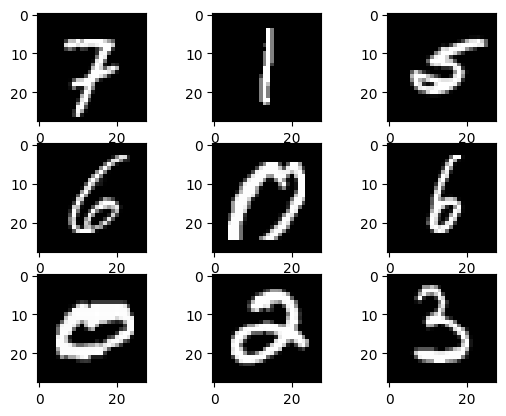

In [35]:
num_of_images_to_plot = 9
plot_images(num_of_images_to_plot, train_images)

Now we will visualize the distribution of the labels from the training dataset using the plot_labels_distribution helper function.

- In the X-axis, we have all the possible digits
- In the Y-axis, we have the total number of such digits

In [36]:
def plot_labels_distribution(data_labels):
  # np.bincount Counts the number of occurrences of each value in array of non-negative ints
  counts = np.bincount(data_labels)
  plt.style.use('seaborn-dark-palette')

  fig, ax = plt.subplots(figsize=(10,5))
  ax.bar(range(10), counts)
  ax.set(xticks = range(10),xlim = [-1,10], title = 'Training data distribution')
  plt.show()

<ipython-input-36-8ee96eabbf91>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


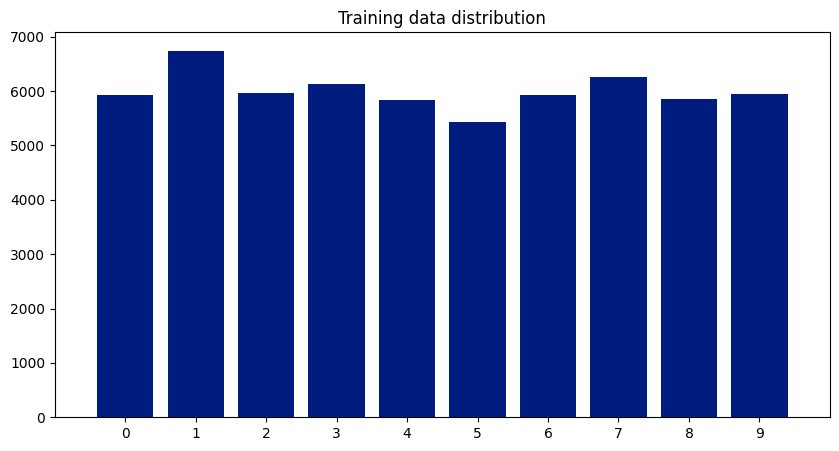

In [37]:
plot_labels_distribution(train_labels)

All ten digits are almost evenly distributed across the entire dataset, which means that no further action is required to balance the distribution of the labels.

## **Data preprocessing**
The following three main preprocessing tasks will be applied to both training and testing images:

- **Image normalization:**
This consists of converting all the pixel values from 0-255 to 0-1. This is relevant for a faster convergence during the training process

- **Reshaping images:**
Instead of having a squared matrix of 28 by 28 for each image, we flatten each one into 784-element vectors in order to make it suitable for the neural network inputs.

- **Label encoding:**
Convert the labels to one-hot encoded vectors. This will avoid the issues we might have with the numerical hierarchy. This way, the model will be biased towards larger digits.

In [61]:
# images = train_images.reshape((train_images.shape[0], 28*28)).astype('float32')
# print(images.shape)

In [62]:
# normalized_images = images / 255
# print(normalized_images)

In [48]:
#print(normalized_images[0])

In [42]:
def preprocess_data(data, label, vector_size, grayscale_size):
  # Normalize to range 0-1
  flattened_images = data.reshape((data.shape[0], vector_size)).astype('float32')
  normalized_images = flattened_images / grayscale_size

  # One-hot encode the labels
  encoded_labels = to_categorical(label)

  return normalized_images, encoded_labels

In [43]:
vector_size = 28*28
grayscale_size = 255

# Preprocessing of the training data
train_images, train_labels = preprocess_data(train_images,
                                             train_labels,
                                             vector_size,
                                             grayscale_size)

# Preprocessing of the training data
test_images, test_labels = preprocess_data(test_images,
                                           test_labels,
                                           vector_size,
                                           grayscale_size)

Now, we'll observe the current maximum and minimum pixel values of both datasets:

In [44]:
print("Training Data")
print(f"- Maximum value {train_images.max()}")
print(f"- Minimum value {train_images.min()}")

print("\n")

print("Testing Data")
print(f"- Maximum value {test_images.max()}")
print(f"- Minimum value {test_images.min()}")

Training Data
- Maximum value 1.0
- Minimum value 0.0


Testing Data
- Maximum value 1.0
- Minimum value 0.0


In [45]:
# One hot encoding of the train and test data labels

print("Training Data Labels")
print(train_labels)

print("\n")

print("Testing Data Labels")
print(test_labels)

Training Data Labels
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


Testing Data Labels
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## **Structure of the network**

In [52]:
hidden_units = 256
num_unique_labels = 10
vector_size = 784 # The image was 28x28

def define_network_architecture():
  network = models.Sequential()

  # First hidden layer
  network.add(Dense(hidden_units, activation='relu', input_shape=(vector_size,)))

  # Second hidden layer
  network.add(Dense(512, activation='relu'))

  # output layer
  network.add(Dense(num_unique_labels, activation='softmax'))

  return network

The above architecture consists of three main layers:

- Input layer of 784 units corresponding to a 28x28 input image
- Hidden layer of 512 units with the ReLU activation
- Output layer with 10 units, which correspond to the number of unique labels with softmax activation function

In [53]:
network = define_network_architecture()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## **Compilation of the network**

In [54]:
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

## **Training of the network**

In [56]:
# Fit the model
batch_size = 256
n_epochs = 15
val_split = 0.2
patience_value = 5

# Fit the model with the callback
history = network.fit(train_images,
                      train_labels,
                      validation_split=val_split ,
                      batch_size=batch_size,
                      epochs=n_epochs)

Epoch 1/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8178 - loss: 0.6179 - val_accuracy: 0.9467 - val_loss: 0.1788
Epoch 2/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9540 - loss: 0.1480 - val_accuracy: 0.9691 - val_loss: 0.1065
Epoch 3/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9724 - loss: 0.0896 - val_accuracy: 0.9628 - val_loss: 0.1161
Epoch 4/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9819 - loss: 0.0625 - val_accuracy: 0.9719 - val_loss: 0.0911
Epoch 5/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9857 - loss: 0.0457 - val_accuracy: 0.9722 - val_loss: 0.0985
Epoch 6/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9893 - loss: 0.0340 - val_accuracy: 0.9754 - val_loss: 0.0916
Epoch 7/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9933 - loss: 0.0246 - val_accuracy: 0.9676 - val_loss: 0.1236
Epoch 8/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9949 - loss: 0.0179 - val_accu

The model is trained for **15** epochs using a batch size of **256**, and **20%** of the training data is used for validation of the model.

After training the model, the training and validation performance history is plotted below.




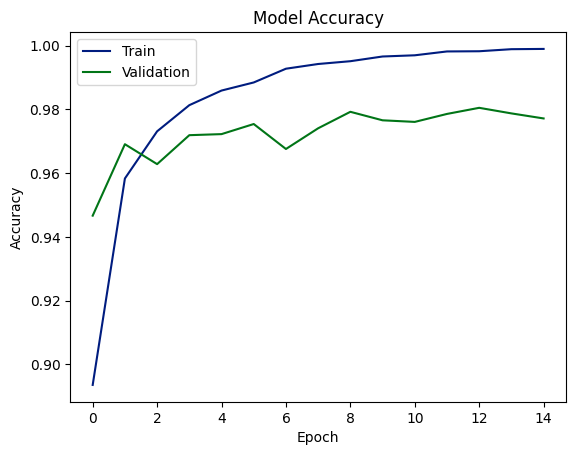

In [57]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc = 'upper left')
plt.show()

## **Evaluation on test data**

In [59]:
loss, acc = network.evaluate(test_images,
                             test_labels,
                             batch_size=batch_size)

print(f"Test accuracy: {100 * acc:.2f}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9774 - loss: 0.1103
Test accuracy: 98.10


The graph indicates that the model has learned to predict outcomes with high accuracy, achieving around 98% on both validation and test data sets.